# Image Classification
### Naïve Bayes, Bayesian regression and Convolutional Neural Networks

In this notebook I will analyse the Fashion MNIST and CIFAR10 dataset available at:<br>

https://www.kaggle.com/zalando-research/fashionmnist/data<br>
https://www.cs.toronto.edu/~kriz/cifar.html<br>

I will try to classify the images from both datasets using different models and analyze their performances.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix, log_loss

## 1 Import the datasets

In [2]:
from keras.datasets import cifar10
from keras.datasets import fashion_mnist

(xTrain_CIFAR, yTrain_CIFAR), (xTest_CIFAR, yTest_CIFAR) = cifar10.load_data()
(xTrain_fMNIST, yTrain_fMNIST), (xTest_fMNIST, yTest_fMNIST) = fashion_mnist.load_data()

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2 Dataset analysis

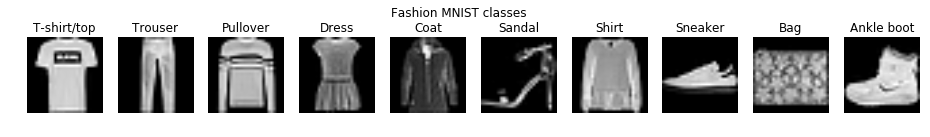

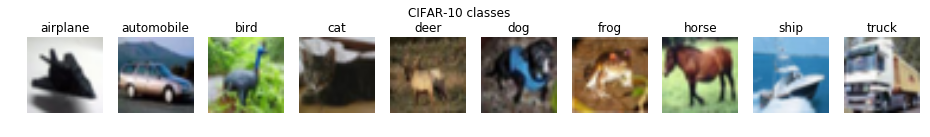

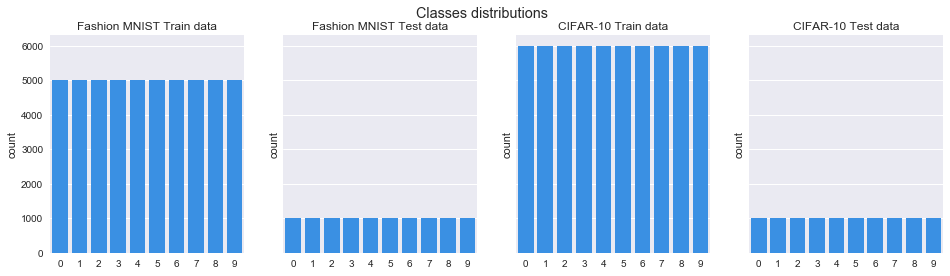

CIFAR-10 x Train: (50000, 32, 32, 3)	y Train: (50000, 1)
CIFAR-10 x Test: (10000, 32, 32, 3)	y Test: (10000, 1)
Fashion MNIST x Train: (60000, 28, 28)	y Train: (60000,)
Fashion MNIST x Test: (10000, 28, 28)	y Test: (10000,)


In [3]:
classesCIFAR = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classesfMNIST = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
n_classes = len(classesCIFAR)

# show one sample per class of the Fashion MNIST dataset
_, ax = plt.subplots(1, n_classes, figsize=(16,2))
for i in range(n_classes):
    idx = np.where(yTrain_fMNIST==i)[0][0]
    ax[i].imshow(xTrain_fMNIST[idx], interpolation='bilinear', cmap = 'gray')
    ax[i].set_title(classesfMNIST[i])
    ax[i].axis('off')
plt.suptitle('Fashion MNIST classes')
plt.show()

# show one sample per class of the CIFAR-10 dataset
_, ax = plt.subplots(1, n_classes, figsize=(16,2))
for i in range(n_classes):
    idx = np.where(yTrain_CIFAR==i)[0][0]
    ax[i].imshow(xTrain_CIFAR[idx], interpolation='bilinear')
    ax[i].set_title(classesCIFAR[i])
    ax[i].axis('off')
plt.suptitle('CIFAR-10 classes')
plt.show()

# show the class distributions over train and test data of both datasets
sns.set()
_, ax = plt.subplots(1, 4, figsize=(16,4), sharey=True)
sns.countplot(yTrain_CIFAR.reshape(-1), ax=ax[0], color='dodgerblue')
ax[0].set_title('Fashion MNIST Train data')
sns.countplot(yTest_CIFAR.reshape(-1), ax=ax[1], color='dodgerblue')
ax[1].set_title('Fashion MNIST Test data')
sns.countplot(yTrain_fMNIST.reshape(-1), ax=ax[2], color='dodgerblue')
ax[2].set_title('CIFAR-10 Train data')
sns.countplot(yTest_fMNIST.reshape(-1), ax=ax[3], color='dodgerblue')
ax[3].set_title('CIFAR-10 Test data')
plt.suptitle('Classes distributions')
plt.show()

# print the shape of the datasets
print("CIFAR-10 x Train: {}\ty Train: {}".format(xTrain_CIFAR.shape, yTrain_CIFAR.shape))
print("CIFAR-10 x Test: {}\ty Test: {}".format(xTest_CIFAR.shape, yTest_CIFAR.shape))
print("Fashion MNIST x Train: {}\ty Train: {}".format(xTrain_fMNIST.shape, yTrain_fMNIST.shape))
print("Fashion MNIST x Test: {}\ty Test: {}".format(xTest_fMNIST.shape, yTest_fMNIST.shape))

The distribution of classes is uniform over both datasets, meaning that we have the same amount of samples for each label. For models such as the naïve Bayes classifier, it is possible to encode this information in the prior, leading to a very general prior distribution that does not make any preference for any class. In the same way, this will allow us to evaluate better our model, because it is not biased towards any particular label.


The datasets are made of <i>D</i>-dimensional vectors for which it is possible to define a gaussian likelihood. The number of features <i>D</i> is very high, expecially for the CIFAR-10 dataset (32 x 32 x 3 = 3072 features), therefore it will be useful to exploit the naïve Bayes assumption, consider them as independent from each other, in order to make it easier to fit the class conditional densities (fitting <i>D</i> univariate distributions is easier than ﬁtting one <i>D</i>-dimensional one).


Finally, the high dimensionality of the input, will make models such as Bayesian regression more computationally expensive, and, more importantly, it may lead to a biased estimation of the variance of the data, lower than the real value.

## 3 Classification with Naïve Bayes classifier

The naïve Bayes classifier is based on the Bayes rule:

$$ P(t_{new} = k\mid X, t, x_{new}) = \dfrac{P(x_{new}\mid t_{new} = k, X, t)P(t_{new} = k)}{\sum_jP(x_{new}\mid t_{new} = i, X, t)P(t_{new} = i)} $$

As already said I will use a Gaussian class-conditional distribution and a uniform prior. In order to make predictions, after having fit the Gaussians parameters and defined the prior, I will use the following approach:

$$ t^* = \underset{t}{argmax}\ P(t\mid x) = \underset{t}{argmax}\ \dfrac{P(x\mid t)P(t)}{P(x)}$$

Where the notation is simplified in order to make the next steps more readable. Since $P(x)$ is just a normalizing constant we can get it out of the equation.

$$ t^* = \underset{t}{argmax}\ P(x\mid t)P(t)$$

Since we are working under the naïve Bayes assumption, the likelihood looks like:

$$ P(x\mid t) = \underset{i = 0}{\overset{D}{\prod}}\dfrac{1}{\sqrt{2\pi\sigma^2_{t, i}}}exp\left( -\dfrac{1}{2}\dfrac{(x_i - \mu_{t, i})^2}{\sigma^2_{t, i}} \right) $$

It is better to work with the log-likelihood because, given the high dimensionality of data, we will have to work with very small numbers and, since the logarithm is monotonically increasing, this will not affect the maximization problem.

$$ log\ P(x\mid t) = \underset{i = 0}{\overset{D}{\sum}}-\dfrac{1}{2}log\ 2\pi -\dfrac{1}{2}log\ \sigma^2_{t, i} -\dfrac{1}{2}\dfrac{(x_i - \mu_{t, i})^2}{\sigma^2_{t, i}} $$

Therefore the final prediction will be:

$$ t^* = \underset{t}{argmax}\ \underset{i = 0}{\overset{D}{\sum}}\left(-\dfrac{1}{2}log\ 2\pi -\dfrac{1}{2}log\ \sigma^2_{t, i} -\dfrac{1}{2}\dfrac{(x_i - \mu_{t, i})^2}{\sigma^2_{t, i}}\right) + log\ P(t) $$

Finally, since we are maximizing over the class, we don't need to include the terms that don't depend on it.

$$ t^* = \underset{t}{argmax}\ \underset{i = 0}{\overset{D}{\sum}}\left(-\dfrac{1}{2}log\ \sigma^2_{t, i} -\dfrac{1}{2}\dfrac{(x_i - \mu_{t, i})^2}{\sigma^2_{t, i}}\right) + log\ P(t) $$


### 3.1 Naïve Bayes classifier implementation

In [4]:
class NaiveBayesClassifier():
    
    def fit(self, X, Y, eps=1e-4):
        
        self.gaussians = dict()
        self.priors = dict()
        self.classes = set(np.uint8(Y))
        
        for label in self.classes:
            # fit mean and variance of the gaussian class conditional density
            X_label = X[Y == label]
            self.gaussians[label] = {
                'mean': X_label.mean(axis=0),
                'variance': X_label.var(axis=0) + eps,
            }
            # fit the class prior
            self.priors[label] = float(len(Y[Y == label])) / len(Y)        
            
    def predict(self, X):
        
        def loglikelihood(X, mean, variance):
            # compute the value of the log class conditional distribution
            return -0.5 * np.sum(np.log(variance)) - 0.5 * np.sum(((X - mean)**2) / variance, 1)

        p = np.zeros((len(X), len(self.classes)))
        # compute the posterior for each data point
        for label, gaussian in self.gaussians.items():
            p[:, label] = loglikelihood(X, gaussian['mean'], gaussian['variance']) + np.log(self.priors[label])
        
        return np.argmax(p, axis=1)

### 3.2 About naïve Bayes classifier 

The naïve Bayes classifier is a very simple and easy to understand non parametric model that needs a very short training time. Its main advantage is that it works under the assumption of features independence, therefore, for a sample $x$, there is no need to consider the interactions between any $x_i$ and $x_j$.

This assumption is practically convenient because normally ther would be a correlation matrix $\Sigma$ of size $D x D$ while now there is $\sigma_i, i = 1, ..., D$. In this case $D = 784$ and $3072$, therefore using the correlation matrix would be far more expensive than working with $D$ variances, also because, in the former scenario, $\Sigma$ should be inverted in order to make predictions.

The main downside of naïve Bayes is that its assumption is most often incorrect, in particular when working with images because each pixel value has some correlation at least with its neighbours.

### 3.3 About data preprocessing

As already said, the main issue of this model stands in its inability to capture relations between features. An initial solution to the problem could be to reduce the dimensionality of data, for example, by performing Principal Component Analysis, but this would only partially solve the issue. A better solution would be to feed the model some preprocessed data that already contain this information, for example, it is possible to get measures of different relations between close pixels by convoluting relevant masks with the images, as it is shown in the last section of this notebook.

### 3.4 Classification

In [5]:
def zeroOneLoss(Y_true, Y_pred):
    return np.mean(Y_true == Y_pred)

In [6]:
# flatten the datasets before feeding them to the classifier
xTrain_fMNIST_flat = xTrain_fMNIST.reshape(xTrain_fMNIST.shape[0], -1)
xTest_fMNIST_flat = xTest_fMNIST.reshape(xTest_fMNIST.shape[0], -1)

xTrain_CIFAR_flat = xTrain_CIFAR.transpose(0, 3, 1, 2).reshape(xTrain_CIFAR.shape[0], -1)
xTest_CIFAR_flat = xTest_CIFAR.transpose(0, 3, 1, 2).reshape(xTest_CIFAR.shape[0], -1)
yTrain_CIFAR_flat = yTrain_CIFAR.reshape(-1)
yTest_CIFAR_flat = yTest_CIFAR.reshape(-1)

In [7]:
# create the model
naiveBayes_fMNIST = NaiveBayesClassifier()

# fit the model on Fashion MNIST training data
start = time.time()
naiveBayes_fMNIST.fit(xTrain_fMNIST_flat, yTrain_fMNIST)
print("Naive Bayes Classifier | Fashion MNIST | Training time: {0:.2f} s".format(time.time() - start))

# make predictions for Fashion MNIST test data
start = time.time()
yPred_fMNIST = naiveBayes_fMNIST.predict(xTest_fMNIST_flat)
print("Naive Bayes Classifier | Fashion MNIST | Prediction time: {0:.2f} s".format(time.time() - start))
print("Naive Bayes Classifier | Fashion MNIST | Accuracy: {0:.2f} %".format(zeroOneLoss(yTest_fMNIST, yPred_fMNIST)*100))

Naive Bayes Classifier | Fashion MNIST | Training time: 0.56 s
Naive Bayes Classifier | Fashion MNIST | Prediction time: 1.27 s
Naive Bayes Classifier | Fashion MNIST | Accuracy: 59.36 %


In [8]:
# create the model
naiveBayes_CIFAR = NaiveBayesClassifier()

# fit the model on CIFAR-10 training data
start = time.time()
naiveBayes_CIFAR.fit(xTrain_CIFAR_flat, yTrain_CIFAR_flat)
print("Naive Bayes Classifier | CIFAR-10 | Training time: {0:.2f} s".format(time.time() - start))

# make predictions for CIFAR-10 test data
start = time.time()
yPred_CIFAR = naiveBayes_CIFAR.predict(xTest_CIFAR_flat)
print("Naive Bayes Classifier | CIFAR-10 | Prediction time: {0:.2f} s".format(time.time() - start))
print("Naive Bayes Classifier | CIFAR-10 | Accuracy: {0:.2f} %".format(zeroOneLoss(yTest_CIFAR_flat, yPred_CIFAR)*100))

Naive Bayes Classifier | CIFAR-10 | Training time: 1.67 s
Naive Bayes Classifier | CIFAR-10 | Prediction time: 4.95 s
Naive Bayes Classifier | CIFAR-10 | Accuracy: 29.76 %


### 3.5 Confusion Matrix

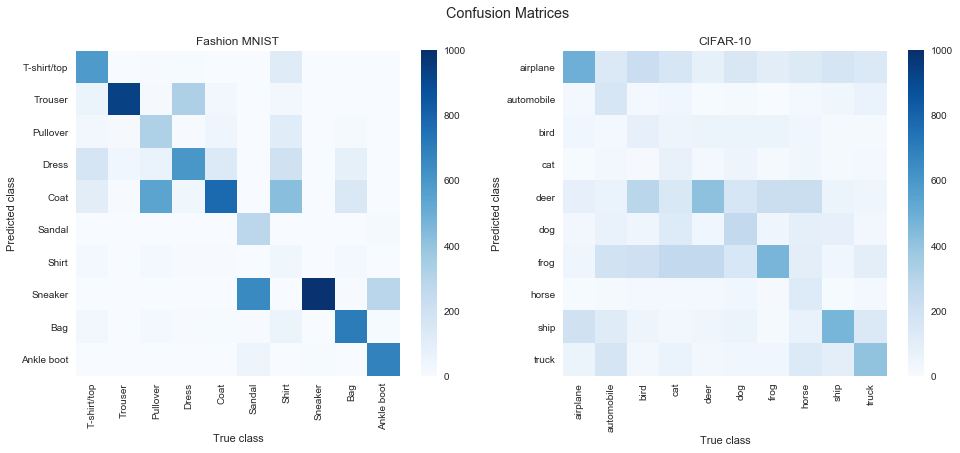

In [9]:
# compute the confusion matrices
confMatrix_fMNIST = confusion_matrix(yTest_fMNIST, yPred_fMNIST)
confMatrix_CIFAR = confusion_matrix(yTest_CIFAR_flat, yPred_CIFAR)

# utility function to plot confusion matrices
def pltConfusionMatrix(conf_matrix, ax, title, ticklabels, xlabel, ylabel):
    sns.heatmap(conf_matrix, 
            square = True,
            annot = False,
            cbar = True,
            xticklabels = ticklabels, 
            yticklabels = ticklabels,
            vmin = 0,
            vmax = 1000,
            cmap = "Blues",
            ax = ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
_, ax = plt.subplots(1, 2, figsize=(16, 6))
pltConfusionMatrix(confMatrix_fMNIST.T, ax[0], 'Fashion MNIST', classesfMNIST, 'True class', 'Predicted class')
pltConfusionMatrix(confMatrix_CIFAR.T, ax[1], 'CIFAR-10', classesCIFAR, 'True class', 'Predicted class')
plt.suptitle('Confusion Matrices')
plt.show()

### 3.6 Performance analysis

The model performed badly on both the datasets, on the Fashion MNIST it reached an accuracy of approximately 60% (it can be tuned by changing the smoothing factor `eps` which is $10^{-4}$ by default) while on the CIFAR-10 it obtained a very poor accuracy of approximately 30%, meaning that it was able to extract some information from the images but still it is close to a random classifier accuracy of 10%. These results underline the need to consider the correlation between features when working with image data.

The confusion matrix of the Fashion MNIST clearly shows which are the most problematic classes. It can be seen that `Shirt` is almost never classified correctly, `Ankle boot` and `Sandal` are often wrongly classified as `Sneaker` in the same way as `Pullover` and `Shirt` are classified as `Coat`. Finally, there are many classes wrongly labeled as `Dress`.

One way to reduce the misclassification rate could be to group similar classes but this would only work because this is a 'simple' dataset, infact, the same solution could not be applied to more complex images such as the CIFAR-10 ones, or different datasets such as the MNIST, where it would not make sense to group numbers together.

Unfortunately, the bad performance on the CIFAR-10 dataset is reflected in his confusion matrix that looks very close to a random one, it gives no particular insights about the current issues apart from the fact that many labels are wrongly classified as `Airplane`, `Frog` or `Deer`.

In order to better visualize the information that the model learned and get other insights on its accuracy it is possible to plot the means and variances of the Gaussian class conditional distributions, as it is done below.

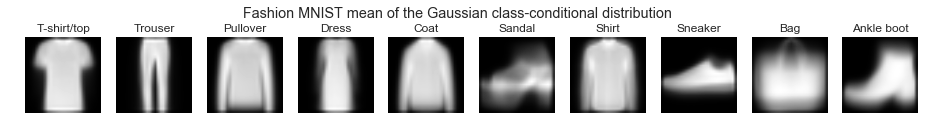

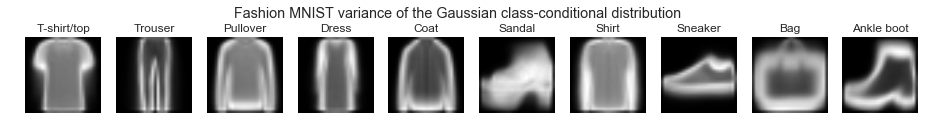

In [10]:
# utility function to plot a parameter of the class conditional distribution
def plotClassConds(naiveBayesModel, classes, parameter, title, reshape):
    _, ax = plt.subplots(1, len(classes), figsize=(16,2))
    for label, gaussian in naiveBayesModel.gaussians.items():
        ax[label].imshow(gaussian[parameter].reshape(reshape), interpolation='bilinear', cmap='gray')
        ax[label].set_title(classes[label])
        ax[label].axis('off')
    plt.suptitle(title)
    plt.show()
    
plotClassConds(naiveBayes_fMNIST, classesfMNIST, 'mean', 
               'Fashion MNIST mean of the Gaussian class-conditional distribution', (28, 28))
plotClassConds(naiveBayes_fMNIST, classesfMNIST, 'variance', 
               'Fashion MNIST variance of the Gaussian class-conditional distribution', (28, 28))

## 4 Bayesian Linear Regression

Bayesian linear regression works by applying Bayes' rule to get a posterior distribution over the weights:

$$ P(w\mid X, t, \sigma^2) = \dfrac{P(t\mid X, w, \sigma^2)P(w)}{P(t\mid X, \sigma^2)} $$

Where $\sigma^2$ is the variance of the data, and it is obtained through Maximum Likelihood Estimate (MLE). In order to solve the problem of marginalization a Gaussian prior and likelihood will be used, so that they are conjugated and it is possible to get a Gaussian posterior with the following parameters:

$$ P(w) = \mathcal{N}(\mu_{prior}, \Sigma_{prior}) $$

$$ P(w\mid X, t, \sigma^2) = \mathcal{N}(\mu, \beta^{-1})$$

$$ \mu = \beta^{-1}\left(\dfrac{1}{\sigma^2}X^\top t + \Sigma_{prior}^{-1}\mu_{prior}\right), \qquad\beta = \dfrac{1}{\sigma^2}X^\top X + \Sigma_{prior}^{-1} $$

Where $\beta$ is the posterior's precision (the inverse of the covariance). Finally, the predictive distribution will be:

$$ P(t_{new}\mid X, t, x_{new}, \sigma^2) = \mathcal{N}(x^\top_{new}\mu,\sigma^2 + x^\top_{new}\beta x_{new}) $$

### 4.1 Bayesian Linear Regression impementation

In [11]:
class BayesianLinearRegression():

    def fit(self, X, Y, prior=[0, 20]):
               
        self.N, self.D = X.shape
        # add a 1 column, use np.matrix to boost MLE computational speed 
        X = np.matrix(np.column_stack([np.ones(self.N), X]))
        Y = Y.reshape(-1, 1)
        
        # set the prior
        self.prior_mean = prior[0]*np.ones(self.D+1)
        self.prior_cov = prior[1]*np.identity(self.D+1)

        # compute MLE parameters
        weights = (X.T.dot(X)).I.dot(X.T).dot(Y)
        error = Y - X.dot(weights)
        self.data_variance = (error.T.dot(error) / self.N)[0]
        
        # compute posterior
        self.posterior_prec = np.linalg.inv(self.prior_cov) + X.T.dot(X) / self.data_variance
        self.posterior_mean = np.linalg.inv(self.prior_cov).dot(self.prior_mean).reshape(-1, 1)
        self.posterior_mean += (X.T.dot(Y)) / self.data_variance
        self.posterior_mean = np.linalg.inv(self.posterior_prec).dot(self.posterior_mean)

    def predict(self, X):
        # add a 1 column
        X = np.matrix(np.column_stack([np.ones(X.shape[0]), X]))
        # compute predictive distribution
        mean_pred = X.dot(self.posterior_mean)
        var_pred = self.data_variance + np.diagonal(X.dot(self.posterior_prec.dot(X.T)))
        return np.array(mean_pred).reshape(-1), np.array(var_pred).reshape(-1)

### 4.2 Regression

In [12]:
# create the model
bayesReg = BayesianLinearRegression()

# fit the model on Fashion MNIST training data
start = time.time()
bayesReg.fit(xTrain_fMNIST_flat, yTrain_fMNIST)
print("Bayesian Regression | Fashion MNIST | Training time: {0:.2f} s".format(time.time() - start))

# make predictions for Fashion MNIST test data
start = time.time()
yPred_fMNIST, yVar_fMNIST = bayesReg.predict(xTest_fMNIST_flat)
print("Bayesian Regression | Fashion MNIST | Prediction time: {0:.2f} s".format(time.time() - start))

Bayesian Regression | Fashion MNIST | Training time: 4.23 s
Bayesian Regression | Fashion MNIST | Prediction time: 3.36 s


In [13]:
# fit the model on CIFAR-10 training data
start = time.time()
bayesReg.fit(xTrain_CIFAR_flat, yTrain_CIFAR_flat)
print("Bayesian Regression | CIFAR-10 | Training time: {0:.2f} s".format(time.time() - start))

# make predictions for CIFAR-10 test data
start = time.time()
yPred_CIFAR, yVar_CIFAR = bayesReg.predict(xTest_CIFAR_flat)
print("Bayesian Regression | CIFAR-10 | Prediction time: {:.2f} s".format(time.time() - start))

Bayesian Regression | CIFAR-10 | Training time: 44.78 s
Bayesian Regression | CIFAR-10 | Prediction time: 15.45 s


### 4.3 Error evaluation

In [14]:
def MSEloss(Y_true, Y_pred):
    return (Y_true - Y_pred).T.dot(Y_true - Y_pred) / Y_pred.shape[0]

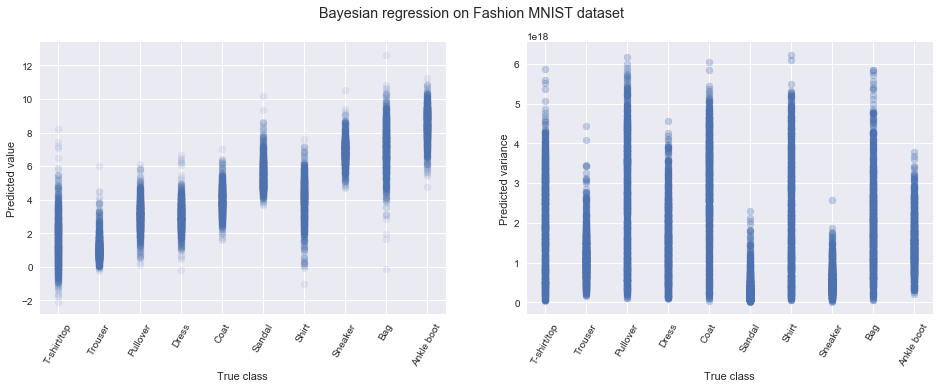

Bayesian Regression | Fashion MNIST | Mean Squared Error: 1.97


In [15]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

# plot the regression prediction versus the true targets
ax[0].scatter(yTest_fMNIST, yPred_fMNIST, alpha=0.1)
ax[0].set_xticks(np.arange(10))
ax[0].set_xticklabels(classesfMNIST, rotation=60)
ax[0].set_xlabel('True class')
ax[0].set_ylabel('Predicted value')

# plot the prediction variance versus the true targets
ax[1].scatter(yTest_fMNIST, yVar_fMNIST, alpha=0.3)
ax[1].set_xticks(np.arange(10))
ax[1].set_xticklabels(classesfMNIST, rotation=60)
ax[1].set_xlabel('True class')
ax[1].set_ylabel('Predicted variance')
plt.suptitle("Bayesian regression on Fashion MNIST dataset")
plt.show()

print("Bayesian Regression | Fashion MNIST | Mean Squared Error: {0:.2f}".format(MSEloss(yTest_fMNIST, yPred_fMNIST)))

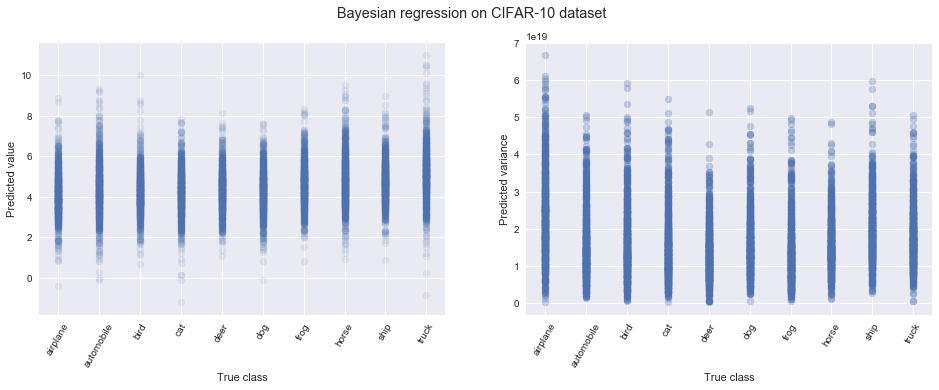

Bayesian Regression | CIFAR-10 | Mean Squared Error: 8.03


In [16]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))

# plot the regression prediction versus the true targets
ax[0].scatter(yTest_CIFAR_flat, yPred_CIFAR, alpha=0.1)
ax[0].set_xticks(np.arange(10))
ax[0].set_xticklabels(classesCIFAR, rotation=60)
ax[0].set_xlabel('True class')
ax[0].set_ylabel('Predicted value')

# plot the prediction variance versus the true targets
ax[1].scatter(yTest_CIFAR_flat, yVar_CIFAR, alpha=0.3)
ax[1].set_xticks(np.arange(10))
ax[1].set_xticklabels(classesCIFAR, rotation=60)
ax[1].set_xlabel('True class')
ax[1].set_ylabel('Predicted variance')
plt.suptitle("Bayesian regression on CIFAR-10 dataset")
plt.show()

print("Bayesian Regression | CIFAR-10 | Mean Squared Error: {0:.2f}".format(MSEloss(yTest_CIFAR_flat, yPred_CIFAR)))

### 4.4 Performance evaluation

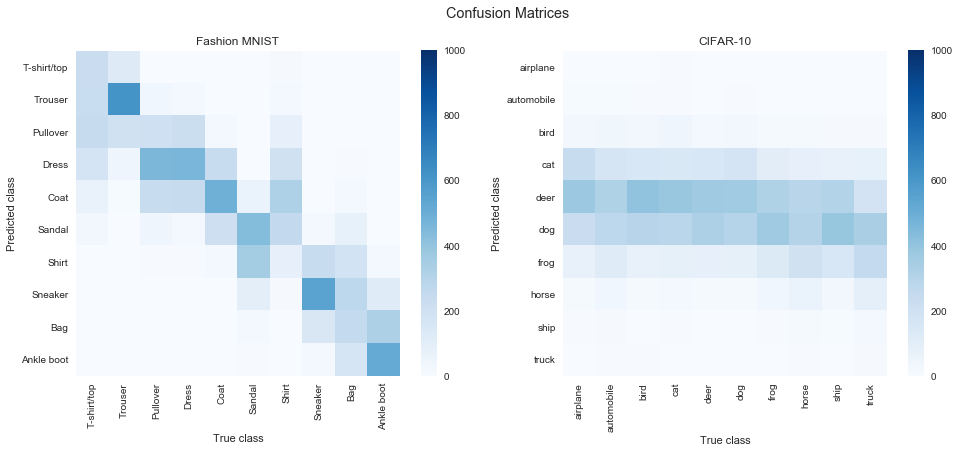

Bayesian Regression | Fashion MNIST | Accuracy: 38.59 %
Bayesian Regression | CIFAR-10 | Accuracy: 10.06 %


In [17]:
# discretize predictions
yPredDisc_fMNIST = np.clip(np.around(yPred_fMNIST), 0, 9)
yPredDisc_CIFAR = np.clip(np.around(yPred_CIFAR), 0, 9)

# compute prediction matrices
confMatrix_fMNIST = confusion_matrix(yTest_fMNIST, yPredDisc_fMNIST)
confMatrix_CIFAR = confusion_matrix(yTest_CIFAR_flat, yPredDisc_CIFAR)

# plot confusion matrices
_, ax = plt.subplots(1, 2, figsize=(16, 6))
pltConfusionMatrix(confMatrix_fMNIST.T, ax[0], 'Fashion MNIST', classesfMNIST, 'True class', 'Predicted class')
pltConfusionMatrix(confMatrix_CIFAR.T, ax[1], 'CIFAR-10', classesCIFAR, 'True class', 'Predicted class')
plt.suptitle('Confusion Matrices')
plt.show()

print("Bayesian Regression | Fashion MNIST | Accuracy: {0:.2f} %".format(zeroOneLoss(yTest_fMNIST, yPredDisc_fMNIST)*100))
print("Bayesian Regression | CIFAR-10 | Accuracy: {0:.2f} %".format(zeroOneLoss(yTest_CIFAR_flat, yPredDisc_fMNIST)*100))

### 4.5 Performance comparison

The Bayesian regression approach performed even worse than the naïve Bayes classifier. On the Fashion MNIST dataset it achieved just 38.59% of accuracy while on CIFAR-10 its performance are the same of a random classifier, 10% of accuracy.

By looking at the predictive variances of our model we can see they have approximatively the same value and they are all very big ($10^{18}-10^{19}$), probably due to the fact that, even with an high number of data points ($5000-6000$), the predictions are not precise and, at least, the model is aware of this.

The predictive means over the classes show the main issues of the model, they are either in a too wide range ($[-2, 12]$ for the Fashion MNIST) or they have the same distribution over classes with mean between 4 and 5 (for CIFAR-10).

This information can be better visualized over a confusion matrix after having transformed the predictions by rounding and clipping them in the range between 0 and 9. Both the prediction matrices show a concentration of values over a line obviously due to the fact that we are applying regression on a classification problem.

For the Fashion MNIST this line correspond to the diagonal of the matrix, in fact 38% of accuracy suggests us that some of the predictions are actually good. For the CIFAR-10 dataset, the line in the confusion matrix is horizontal, in fact, while the Fashion MNIST predictive means increase (or, more generally, change) along the different classes, the CIFAR predictive means have almost the same distribution.

Finally, it is worth to notice the difference in the execution time between the two approaches, while the naïve Bayes classifier is pretty fast on both dataset, Bayesian regression takes at least ten times more time.

### 4.6 Regression limitations

Indeed linear regression is not the appropriate model for our problem because it looks for a linear relation between the pixels and the class of the image which is just the numerical encoding of its content.

Apart from this main conceptual limitation, the model presents some other minor issues, for example, it assigns fixed weights to each pixel, therefore it is not robust to image translation or scaling.

Furthermore, regression has the same problem of naïve Bayes, it is not able to capture the structure of the data and so, it cannot recognize patterns in images.

## 5 Naïve Bayes and Convolutional Neural Networks

The state-of-the-art in image classification suggests that convolutional layers in convolutional neural networks yield most of the improvements compared to standard neural networks. The reason is that they are capable of modeling spatial patterns through the hierarchical analysis of patches of images.

In order to improve the performances of the naïve Bayes classifier, it woud be good to train a convolutional neural network on the dataset and then feed the output of the convolutional layer to the classfier. In other words, we will use the first layers of the trained neural network to do the necessary data preprocessing.

### 5.1 LeNet 5 in PyTorch

LeNet 5 is one of the first Convolutional Neural Network architectures, it is made of two convolutional-pooling layers and three fully connected layers, as showed in the picture below.
<img src="https://world4jason.gitbooks.io/research-log/content/deepLearning/CNN/img/lenet.png" align="center">

Before using the CNN together with the naïve Bayes classifier, it needs to be trained so that its weights are able to extract the correct features from the images. In order to do so LeNet 5 will be implemented using PyTorch, one of the many deep learning frameworks available.

In order to be able to retrieve the output of the convolutional layers in the final sections, I added some boolean variables to make the <i>forward()</i> function return the intermediate values.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [19]:
class LeNet5(nn.Module):   
    def __init__(self, img_size, in_channels=1):
        super(LeNet5, self).__init__()
        self.convPool1 = nn.Sequential(
            nn.Conv2d(in_channels, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.convPool2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        flat_size = int(img_size/4 - 2)**2 * 16
        self.fc1 = nn.Linear(flat_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, conv1=False, conv2=False):
        x = self.convPool1(x)
        if conv1: return x.view(x.size(0), -1) 
        x = self.convPool2(x)
        x = x.view(x.size(0), -1)
        if conv2: return x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
    def train(self, dataLoader, n_epochs, criterion, optimizer):
        losses = []
        start = time.time()
        for epoch in range(n_epochs):
            for X, Y in dataLoader:
                X = Variable(X)
                Y = Variable(Y)

                # zero the parameters gradients
                optimizer.zero_grad()

                # feedforward
                outputs = leNet5.forward(X)
                loss = criterion(outputs, Y)
                losses.append(loss.data.numpy()[0])

                # backpropagation
                loss.backward()

                # update the weights
                optimizer.step()

        end = time.time() - start
        return losses, end
    
    def accuracy(self, dataLoader):
        correct = 0
        total = 0
        for X, Y in dataLoader:
            X = Variable(X)
            Y = Variable(Y)
            outputs = leNet5.forward(X)
            _, predicted = torch.max(outputs.data, 1)
            total += Y.size(0)
            correct += (predicted.numpy() == Y.data.numpy()).sum().item()
        return correct / total

### 5.2 Fashion MNIST Image Classification with LeNet 5

The Convolutional Neural Network takes the input in its natural shape, so there is no need to flatten it as it has been done for the naïve Bayes classifier or for the Bayesian regression. Moreover, data will be transformed into PyTorch tensors and fed into dataloaders in order to ease the mini-batch training process.

In [20]:
# convert data to tensors
xTrain_fMNIST_torch = xTrain_fMNIST.reshape(60000, 28, 28, 1).transpose(0, 3, 2, 1)
xTrain_fMNIST_torch = torch.Tensor(xTrain_fMNIST_torch)
yTrain_fMNIST_torch = torch.LongTensor(yTrain_fMNIST)

xTest_fMNIST_torch = xTest_fMNIST.reshape(10000, 28, 28, 1).transpose(0, 3, 2, 1)
xTest_fMNIST_torch = torch.Tensor(xTest_fMNIST_torch)
yTest_fMNIST_torch = torch.LongTensor(yTest_fMNIST)

# create the datasets loaders
trainData = TensorDataset(xTrain_fMNIST_torch, yTrain_fMNIST_torch)
trainDataLoader_fMNIST = DataLoader(trainData, batch_size=256, shuffle=True)

testData = TensorDataset(xTest_fMNIST_torch, yTest_fMNIST_torch)
testDataLoader_fMNIST = DataLoader(testData, batch_size=256, shuffle=True)

In [21]:
# create the CNN
leNet5 = LeNet5(img_size=28)

# set training parameters
n_epochs = 20
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet5.parameters(), lr=learning_rate)

# train the network
losses, trainTime = leNet5.train(trainDataLoader_fMNIST, n_epochs, criterion, optimizer)

print("Le-Net 5 | Fashion MNIST | Training time: {} min {} s".format(int(trainTime/60), int(trainTime%60)))

Le-Net 5 | Fashion MNIST | Training time: 9 min 42 s


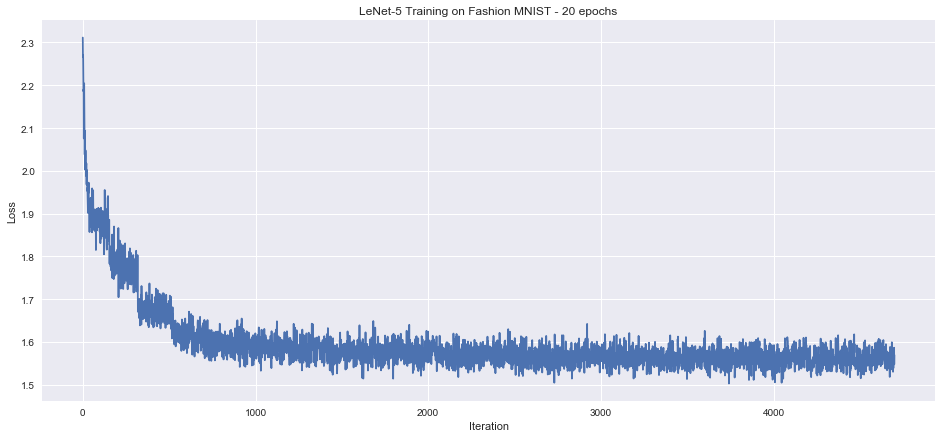

In [22]:
# plot the training progress
_, ax = plt.subplots(figsize=(16, 7))
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("LeNet-5 Training on Fashion MNIST - {} epochs".format(n_epochs))
plt.show()

In [23]:
start = time.time()
acc = leNet5.accuracy(testDataLoader_fMNIST)
print("Le-Net 5 | Fashion MNIST | Prediction time: {:.2f} s".format(time.time() - start))
print('Le-Net 5 | Fashion MNIST | Accuracy on 10000 test images: {:.2f}%'.format(acc*100))

Le-Net 5 | Fashion MNIST | Prediction time: 2.12 s
Le-Net 5 | Fashion MNIST | Accuracy on 10000 test images: 88.11%


As showed above, the network performs a lot better than naïve Bayes classifier and Bayesian regression after just a few epochs of training. Unfortunately, even if the prediction time is very low, the training time is more relevant than for the previous models.

### 5.2 Fashion MNIST Image Classification with Naïve Bayes and CNN

In the previous sections of this notebook I already talked about the importance of data preprocessing and, most importantly, capturing the relations between pixels. This last topic is what improves the CNNs performances with respect to other models such as normal neural networks. In order to understand the convolutional layers it is good to visualize the kernels used for the convolution, in fact, their task is exactly to capture the most relevant features of an image as relations between pixels in a defined neighbourhood ($5x5$ in this case).

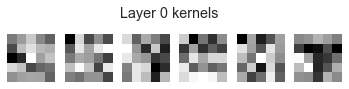

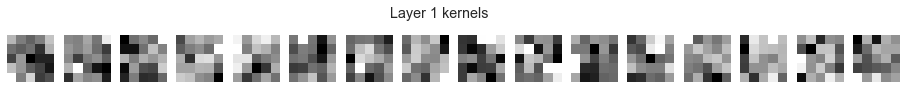

In [24]:
def pltKernels(nn, n_layers):
    model_layers = [i for i in nn.children()]
    for l in range(n_layers):
        kernels = model_layers[l][0].weight.data.numpy()
        n_kernels = kernels.shape[0]
        _, ax = plt.subplots(1, n_kernels, figsize=(n_kernels,1.5))
        for i in range(n_kernels):
            ax[i].imshow(kernels[i][0,:,:], cmap='gray')
            ax[i].axis('off')
            ax[i].set_xticklabels([])
            ax[i].set_yticklabels([])
        plt.suptitle("Layer {} kernels".format(l))
        
pltKernels(leNet5, 2)

Now the idea is to use this kernels, thus the convolutional layers of the network, to get a new set of features. I will use the outputs of the first layer of the network, then the second layer, and finally, try to put them together and merge them with the original dataset too.

In [25]:
# utility function to get the outputs of the CNN at the given convolutional layer
def getFeatures(X, batch_size, net, conv1=False, conv2=False, n_channels=1):
    def next_batch(data):
        # generate mini batches
        for i in np.arange(0, len(data), batch_size):
            offset = min(i+batch_size, len(data))
            yield np.array(data[i:offset])
   
    first = True
    inputs = np.array([])
    for inputs_batch in next_batch(X):
        features = net.forward(Variable(torch.Tensor(inputs_batch)), conv1, conv2)
        features = features.data.numpy()
        if first:
            inputs = features
            first = False
        else:
            inputs = np.append(inputs, features, axis=0)
    return inputs   

#### Features from the first convolutional layer

In [26]:
naiveBayes = NaiveBayesClassifier()

fTrain_fMNIST_1 = getFeatures(xTrain_fMNIST_torch, 512, leNet5, conv1=True)
fTest_fMNIST_1 = getFeatures(xTest_fMNIST_torch, 512, leNet5, conv1=True)

naiveBayes.fit(fTrain_fMNIST_1, yTrain_fMNIST)

yPred_fMNIST = naiveBayes.predict(fTest_fMNIST_1)

print("Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_fMNIST, yTest_fMNIST)*100))

Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: 65.39 %


#### Features from the second convolutional layer

In [27]:
fTrain_fMNIST_2 = getFeatures(xTrain_fMNIST_torch, 512, leNet5, conv2=True)
fTest_fMNIST_2 = getFeatures(xTest_fMNIST_torch, 512, leNet5, conv2=True)

naiveBayes.fit(fTrain_fMNIST_2, yTrain_fMNIST)

yPred_fMNIST = naiveBayes.predict(fTest_fMNIST_2)

print("Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_fMNIST, yTest_fMNIST)*100))

Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: 78.23 %


#### Features from the first and the second convolutional layers

In [28]:
fTrain_fMNIST_12 = np.append(fTrain_fMNIST_1, fTrain_fMNIST_2, axis=1)
fTest_fMNIST_12 = np.append(fTest_fMNIST_1, fTest_fMNIST_2, axis=1)

naiveBayes.fit(fTrain_fMNIST_12, yTrain_fMNIST)

yPred_fMNIST = naiveBayes.predict(fTest_fMNIST_12)

print("Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_fMNIST, yTest_fMNIST)*100))

Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: 71.64 %


#### Feature expansion: original features + second convolutional layer

In [29]:
xTrain_fMNIST_Extended = np.append(fTrain_fMNIST_2, xTrain_fMNIST_flat, axis=1)
xTest_fMNIST_Extended = np.append(fTest_fMNIST_2, xTest_fMNIST_flat, axis=1)

naiveBayes.fit(xTrain_fMNIST_Extended, yTrain_fMNIST)

yPred_fMNIST = naiveBayes.predict(xTest_fMNIST_Extended)

print("Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_fMNIST, yTest_fMNIST)*100))

Naive Bayes Classifier + CNN | Fashion MNIST | Accuracy: 70.34 %


The naïve Bayes classifier with new input features performed overall better than the first implementation. Anyway it is possible to see how it performs better with the features from the second layer than with the features from the first one. This is due to the fact that the second layer is capable to capture more complex pattern of an image because it works on top of another convolutional layer, e.g. if the first layer captures lines in the image, the second could recognize shapes.

Furthermore, the accuracy decreases when mixing the features from the first and second layers or the original features with the second layer ones. This is due to how the naïve Bayes classifier works: it has no parameters, therefore it cannot assign weights to features to give them different importance. As a result of this, the accuracy using the first and second layer features is better than using the first one but worst than using just the second one. Moreover, the same results occur on the final experiment, hence this is probably due to the tradeoff between good and bad features in the dataset.

### 5.3 CIFAR-10 Image Classification with Naïve Bayes and CNN

In [30]:
# convert data to tensors
xTrain_CIFAR_torch = xTrain_CIFAR.reshape(50000, 32, 32, 3).transpose(0, 3, 2, 1)
xTrain_CIFAR_torch = torch.Tensor(xTrain_CIFAR_torch)
yTrain_CIFAR_torch = torch.LongTensor(yTrain_CIFAR.reshape(-1))

xTest_CIFAR_torch = xTest_CIFAR.reshape(10000, 32, 32, 3).transpose(0, 3, 2, 1)
xTest_CIFAR_torch = torch.Tensor(xTest_CIFAR_torch)
yTest_CIFAR_torch = torch.LongTensor(yTest_CIFAR.reshape(-1))

# create the datasets loaders
trainData = TensorDataset(xTrain_CIFAR_torch, yTrain_CIFAR_torch)
trainDataLoader_CIFAR = DataLoader(trainData, batch_size=128, shuffle=True)

testData = TensorDataset(xTest_CIFAR_torch, yTest_CIFAR_torch)
testDataLoader_CIFAR = DataLoader(testData, batch_size=128, shuffle=True)

In [31]:
# create the CNN
leNet5 = LeNet5(img_size=32, in_channels=3)

# set training parameters
n_epochs = 20
learning_rate = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet5.parameters(), lr=learning_rate)

# train the network
losses, trainTime = leNet5.train(trainDataLoader_CIFAR, n_epochs, criterion, optimizer)

print("Le-Net 5 | CIFAR-10 | Training time: {} min {} s".format(int(trainTime/60), int(trainTime%60)))

Le-Net 5 | CIFAR-10 | Training time: 11 min 36 s


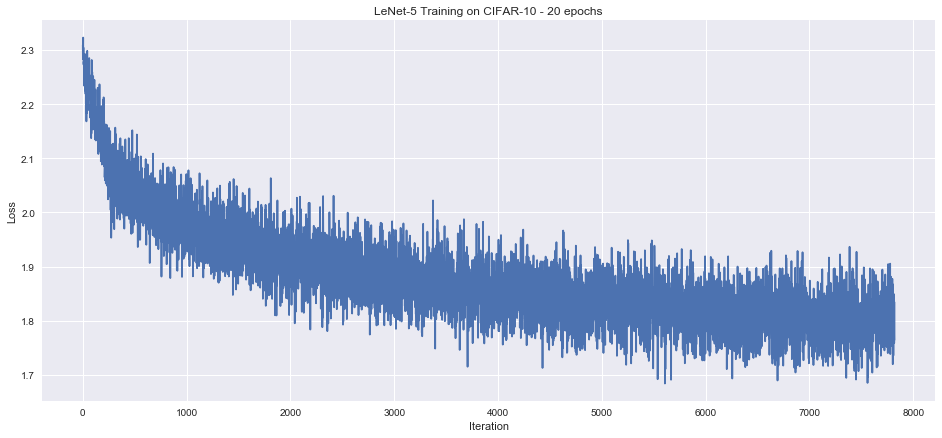

In [32]:
# plot the training progress
_, ax = plt.subplots(figsize=(16, 7))
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("LeNet-5 Training on CIFAR-10 - {} epochs".format(n_epochs))
plt.show()

In [33]:
start = time.time()
acc = leNet5.accuracy(testDataLoader_CIFAR)
print("Le-Net 5 | CIFAR-10 | Prediction time: {:.2f} s".format(time.time() - start))
print('Le-Net 5 | CIFAR-10 | Accuracy on 10000 test images: {:.2f}%'.format(acc*100))

Le-Net 5 | CIFAR-10 | Prediction time: 4.23 s
Le-Net 5 | CIFAR-10 | Accuracy on 10000 test images: 58.34%


The CNN takes more time to perform each epoch because it is dealing with a bigger dataset in terms of features. Moreover, the complexity of the CIFAR images, that are bigger and have more channels than the Fashion MNIST, reflects also on the final loss and accuracy.

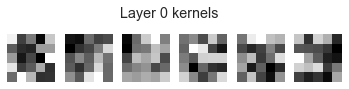

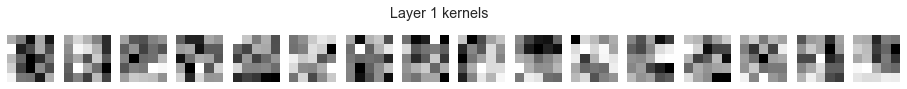

In [34]:
pltKernels(leNet5, 2)

#### Features from the first convolutional layer

In [35]:
fTrain_CIFAR_1 = getFeatures(xTrain_CIFAR_torch, 512, leNet5, conv1=True)
fTest_CIFAR_1 = getFeatures(xTest_CIFAR_torch, 512, leNet5, conv1=True)

naiveBayes.fit(fTrain_CIFAR_1, yTrain_CIFAR_flat)

yPred_CIFAR = naiveBayes.predict(fTest_CIFAR_1)

print("Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_CIFAR, yTest_CIFAR_flat)*100))

Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: 33.10 %


#### Features from the second convolutional layer

In [36]:
fTrain_CIFAR_2 = getFeatures(xTrain_CIFAR_torch, 512, leNet5, conv2=True)
fTest_CIFAR_2 = getFeatures(xTest_CIFAR_torch, 512, leNet5, conv2=True)

naiveBayes.fit(fTrain_CIFAR_2, yTrain_CIFAR_flat)

yPred_CIFAR = naiveBayes.predict(fTest_CIFAR_2)

print("Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_CIFAR, yTest_CIFAR_flat)*100))

Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: 43.22 %


#### Features from the first and the second convolutional layers

In [40]:
fTrain_CIFAR_12 = np.append(fTrain_CIFAR_1, fTrain_CIFAR_2, axis=1)
fTest_CIFAR_12 = np.append(fTest_CIFAR_1, fTest_CIFAR_2, axis=1)

naiveBayes.fit(fTrain_CIFAR_12, yTrain_CIFAR_flat)

yPred_CIFAR = naiveBayes.predict(fTest_CIFAR_12)

print("Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_CIFAR, yTest_CIFAR_flat)*100))

Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: 37.85 %


#### Feature expansion: original features + second convolutional layer

In [41]:
xTrain_CIFAR_Extended = np.append(fTrain_CIFAR_2, xTrain_CIFAR_flat, axis=1)
xTest_CIFAR_Extended = np.append(fTest_CIFAR_2, xTest_CIFAR_flat, axis=1)

naiveBayes.fit(xTrain_CIFAR_Extended, yTrain_CIFAR_flat)

yPred_CIFAR = naiveBayes.predict(xTest_CIFAR_Extended)

print("Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: {0:.2f} %".format(zeroOneLoss(yPred_CIFAR, yTest_CIFAR_flat)*100))

Naïve Bayes Classifier + CNN | CIFAR-10 | Accuracy: 34.95 %


The final results on the CIFAR-10 datasets are coherent with the previous sperimentation on the Fashion MNIST datasets even if a less accurate network has been used together with a different (and more complex) dataset.